# LEVA GLI EASYNEG DA SMALL_TRAIN

# Code

In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import pickle
import math
import torch
from tqdm.notebook import tqdm
import seaborn as sns
from torch.utils.data import DataLoader
# if its_jupyter_notebook:
#     sys.argv = [''] #Remove this if it's not a jupyter notebook!

import sys
sys.path.insert(0, '..')
#from config import *
from dataset.data import (
    RNADataset,
    EasyPosAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    plot_sample,
    #plot_sample2,
    seed_everything,
)
from config import *

In [3]:
df_genes = pd.read_csv(os.path.join(processed_files_dir, "df_genes.csv"))
df = pd.read_csv(os.path.join(processed_files_dir, "final_df.csv"))

In [4]:
#the N in the cdna creates problem with the tokenizer
df_genes['problematic_set'] = df_genes['cdna'].apply(lambda x: False if (set(x) - set({'A', 'C', 'G', 'T'}) == set()) else True)
genesN = set(df_genes[df_genes.problematic_set].gene_id.values)
df = df[~(df.gene1.isin(genesN))|(df.gene2.isin(genesN))].reset_index(drop = True)

In [5]:
with open(os.path.join(rna_rna_files_dir, f"gene_pairs_training.txt"), "rb") as fp:  # Unpickling
    subset_train = pickle.load(fp)
    subset_train = pd.Series(subset_train).str.split('_', expand = True)
    genes_train = set(subset_train[0]).union(set(subset_train[1]))

In [6]:
limit_small_rna = MAX_RNA_SIZE + 1000
limit_medium_rna = int(MAX_RNA_SIZE * 1.5)

df_small = df[(df.length_1<=limit_small_rna)&(df.length_2<=limit_small_rna)].reset_index(drop=True)
df_big = df[(df.length_1>limit_medium_rna)&(df.length_2>limit_medium_rna)].reset_index(drop=True)
df_medium = df[~df.couples.isin(set(df_small.couples).union(set(df_big.couples)))].reset_index(drop=True)
assert (df_small.shape[0]+df_medium.shape[0]+df_big.shape[0]) == df.shape[0]
perc_small = np.round(df_small.shape[0]/df.shape[0]*100, 1)
perc_medium = np.round(df_medium.shape[0]/df.shape[0]*100, 1)
perc_big = np.round(df_big.shape[0]/df.shape[0]*100, 1)
print(f'The amount of data (in the entire dataset) that will be sampled once is {perc_small}% ')
print(f'The amount of data (in the entire dataset) that will be sampled twice is {perc_medium}% ')
print(f'The amount of data (in the entire dataset) that will be sampled 3 times is {perc_big}% ')

The amount of data (in the entire dataset) that will be sampled once is 65.6% 
The amount of data (in the entire dataset) that will be sampled twice is 33.0% 
The amount of data (in the entire dataset) that will be sampled 3 times is 1.4% 


In [7]:
def create_sample_dict(id_couple, sample):
        d = {
            'id_sample':id_couple,
            'couple':sample.couple_id,
            'gene1':sample.gene1,
            'gene2':sample.gene2,
            'x1':sample.bbox.x1,
            'x2':sample.bbox.x2,
            'y1':sample.bbox.y1,
            'y2':sample.bbox.y2,
            'interacting':sample.interacting,
            'policy':sample.policy,
            'cdna1':sample.gene1_info["cdna"][sample.bbox.x1:sample.bbox.x2],
            'cdna2':sample.gene2_info["cdna"][sample.bbox.y1:sample.bbox.y2],
            'seed_x1':sample.seed_interaction_bbox.x1,
            'seed_x2':sample.seed_interaction_bbox.x2,
            'seed_y1':sample.seed_interaction_bbox.y1,
            'seed_y2':sample.seed_interaction_bbox.y2,
            'protein_coding1':sample.gene1_info["protein_coding"],
            'protein_coding2':sample.gene2_info["protein_coding"],
            'original_length1':len(sample.gene1_info["cdna"]),
            'original_length2':len(sample.gene2_info["cdna"]),
        }
        return d

def get_dataset(ep_per_sample, sn_per_sample, en_persample, hn_per_sample, df_genes, df, subset_file, pos_width_multipliers, pos_height_multipliers, neg_width_windows, neg_height_windows):
    assert np.round(sum(pos_width_multipliers.values()), 4) == np.round(sum(neg_width_windows.values()), 4) == 1
    pol = [
        EasyPosAugment(
        per_sample=ep_per_sample,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_width_multipliers,
        height_multipliers=pos_height_multipliers,
        ),
        SmartNegAugment(
            per_sample=sn_per_sample,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=pos_width_multipliers,
            height_multipliers=pos_height_multipliers,
        ),
        EasyNegAugment(
            per_sample=en_persample,
            width_windows=neg_width_windows,
            height_windows=neg_height_windows,
        ),
    ]
    if hn_per_sample>0:
        pol.append(
            HardNegAugment(
                per_sample=hn_per_sample,
                width_windows=neg_width_windows,
                height_windows=neg_height_windows,
            )
        )
    dataset = RNADataset(
            gene2info=df_genes,
            interactions=df,
            subset_file=subset_file,
            augment_policies=pol,
    )
    return dataset 

def create_gene_count(df, unbalanced_ratio):
    gene_count = pd.concat([df[['gene1', 'interacting']].rename({'gene1':'gene'}, axis = 1),
                            df[['gene2','interacting']].rename({'gene2':'gene'}, axis = 1)], axis = 0).reset_index(drop = True)
    g = gene_count.groupby('gene').sum()
    g['not_interacting'] = gene_count.groupby('gene').count() - gene_count.groupby('gene').sum()
    g['not_interacting'] = g['not_interacting']*unbalanced_ratio
    g = g.reset_index() #add the gene column from the index
    g['diff'] = g['not_interacting'] - g['interacting']
    g['abs_diff'] = g['diff'].abs()
    g['tot'] = g['interacting'] + g['not_interacting']
    g['abs_diff_weighted'] = g['tot']*g['abs_diff']
    return g

In [8]:
pos_width_multipliers = {1000000: 1.}
pos_height_multipliers = pos_width_multipliers
neg_width_windows = {(MAX_RNA_SIZE-1, MAX_RNA_SIZE): float(1),}
neg_height_windows = neg_width_windows

# Data loader train

In [9]:
set_data = 'training' 
assert set_data in ['training', 'val', 'test']
subset_file = os.path.join(rna_rna_files_dir, f"gene_pairs_{set_data}.txt")

id_couple = 0
meta = {}

In [ ]:
small_train = get_dataset(ep_per_sample=1, sn_per_sample=1, en_persample=0.2, hn_per_sample=0, 
                          df_genes=df_genes, df=df_small, subset_file=subset_file, 
                          pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                          neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(small_train), total = len(small_train)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
medium_train = get_dataset(ep_per_sample=2, sn_per_sample=2, en_persample=0.2, hn_per_sample=0, 
                           df_genes=df_genes, df=df_medium, subset_file=subset_file,
                           pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                           neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(medium_train), total = len(medium_train)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
big_train = get_dataset(ep_per_sample=3, sn_per_sample=3, en_persample=0.2, hn_per_sample=0, 
                        df_genes=df_genes, df=df_big, subset_file=subset_file, 
                        pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                        neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(big_train), total = len(big_train)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
df_meta = pd.DataFrame.from_dict(meta, 'index')
df_meta['lencdna1'] = df_meta.apply(lambda x: len(x.cdna1), axis = 1)
df_meta['lencdna2'] = df_meta.apply(lambda x: len(x.cdna2), axis = 1)
assert ((df_meta.x2 - df_meta.x1)==(df_meta.lencdna1)).all()
assert ((df_meta.y2 - df_meta.y1)==(df_meta.lencdna2)).all()

m = df_meta[df_meta.policy.isin({'smartneg', 'easypos'})]
assert (m.seed_x1 >= m.x1).all()
assert (m.seed_y1 >= m.y1).all()
assert ((m.seed_x2) <= (m.x2)).all()
assert ((m.seed_y2) <= (m.y2)).all()

93092 14845
6.2709329740653414


/data01/gbini/projects/RNA-RNA/src/../dataset/data.py:1306: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot([0, width],[0, height], 'ro', color = 'white')


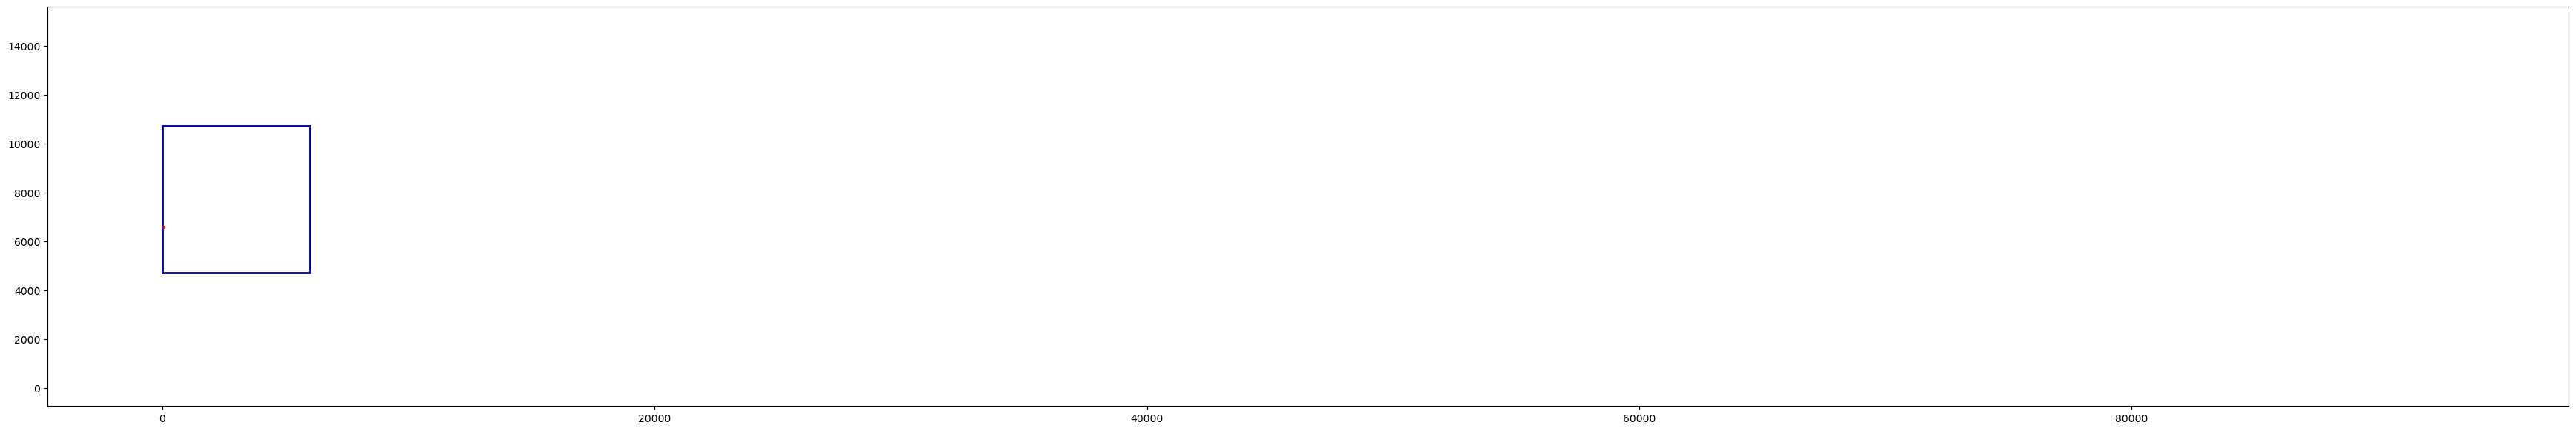

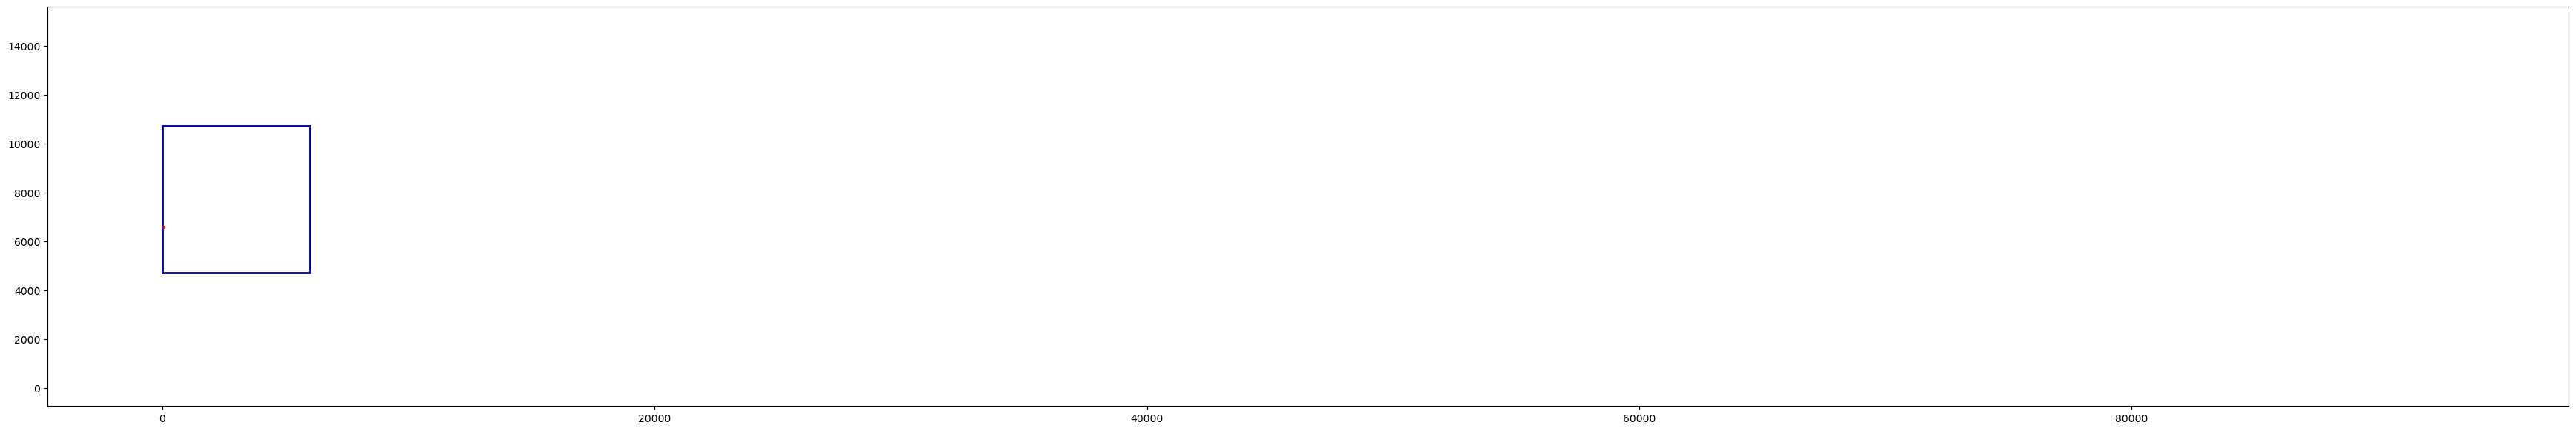

In [25]:
plot_sample(sample, True)

### Controllo se alcuni geni hanno un arricchimento solo nei positivi o solo nei negativi.

In [27]:
original_shape = df_meta.shape[0]

unbalanced_ratio = df_meta.interacting.value_counts()[True]/df_meta.interacting.value_counts()[False]
print(f'unbalanced_ratio:{unbalanced_ratio:.2f}')

gene_count = create_gene_count(df_meta, unbalanced_ratio)
weighted_average = np.round(gene_count['abs_diff_weighted'].sum()/gene_count['tot'].sum(),2)
print(f'{weighted_average=}')
df_meta = df_meta.merge(gene_count[['gene', 'diff']], left_on = 'gene1', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff1'}, axis =1)
df_meta = df_meta.merge(gene_count[['gene', 'diff']], left_on = 'gene2', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff2'}, axis =1)
df_meta['diff'] = df_meta['diff1'] + df_meta['diff2']

unbalanced_ratio:0.44
weighted_average=18.9


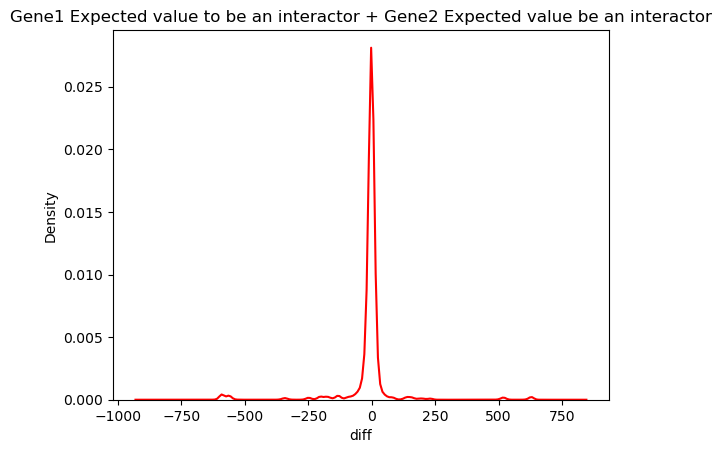

In [29]:
sns.kdeplot(df_meta['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor')
plt.show()

In [ ]:
tolerance = 50
print(f'before:{df_meta.shape[0]}')
problematics = df_meta[(df_meta['diff']>tolerance)|(df_meta['diff']<-tolerance)]
subsetted = df_meta[(df_meta['diff']<tolerance)&(df_meta['diff']>-tolerance)]
print(f'after:{subsetted.shape[0]}')
perc = np.round(100 - subsetted.shape[0]/original_shape*100, 2)
print(f'lost:{perc}%')

In [30]:
df_meta = subsetted.reset_index(drop = True).drop(['diff', 'diff1', 'diff2'], axis =1)

In [31]:
unbalanced_ratio = df_meta.interacting.value_counts()[True]/df_meta.interacting.value_counts()[False]
print(f'unbalanced_ratio:{unbalanced_ratio:.2f}')

gene_count = create_gene_count(df_meta, unbalanced_ratio)
weighted_average = np.round(gene_count['abs_diff_weighted'].sum()/gene_count['tot'].sum(),2)
print(f'{weighted_average=}')
df_meta = df_meta.merge(gene_count[['gene', 'diff']], left_on = 'gene1', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff1'}, axis =1)
df_meta = df_meta.merge(gene_count[['gene', 'diff']], left_on = 'gene2', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff2'}, axis =1)
df_meta['diff'] = df_meta['diff1'] + df_meta['diff2']

unbalanced_ratio:0.44
weighted_average=4.59


In [32]:
perc = np.round(100 - df_meta.shape[0]/original_shape*100, 2)
print(f'In total, I lost the:{perc}% of the pairs')

In total, I lost the:10.44% of the pairs


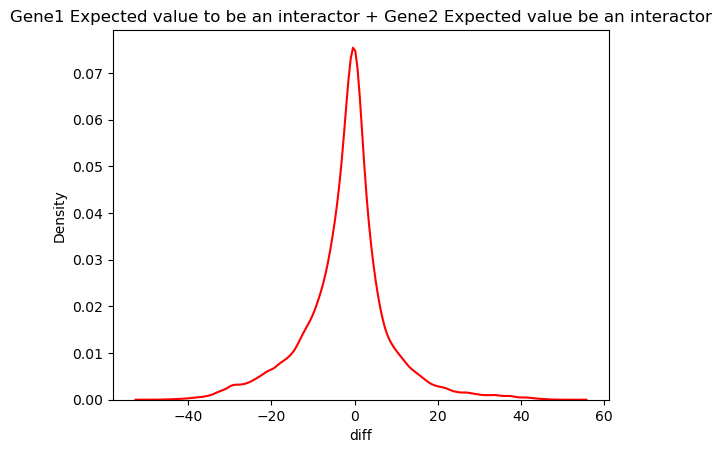

In [33]:
sns.kdeplot(df_meta['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor')
plt.show()

In [34]:
df_meta.to_csv(os.path.join(metadata_dir, f'{set_data}.csv'), index = False)

If you want to sample from problematics pair such that we have all the genes, comment this
```{python}
df_meta = subsetted.reset_index(drop = True).drop(['diff', 'diff1', 'diff2'], axis =1)
```
and uncomment this

```{python}
all_problematic_genes = set(problematics.gene2).union(set(problematics.gene1))
genes_to_sample = all_problematic_genes - set(subsetted.gene1).union(set(subsetted.gene2))

id_to_keep = []
for gene in genes_to_sample:
    subset = problematics[(problematics.gene1 == gene) | (problematics.gene2 == gene)]
    n_sample = min(3,subset.shape[0])
    #n_sample = 1
    id_to_keep = id_to_keep + list(subset.sample(n_sample)['id_sample'])
id_to_keep = set(id_to_keep)
problematics_to_sample = problematics[problematics.id_sample.isin(id_to_keep)]

df_meta = pd.concat([subsetted, problematics_to_sample], axis = 0).reset_index(drop = True).drop(['diff', 'diff1', 'diff2'], axis =1)
assert all_problematic_genes - set(df_meta.gene2).union(set(df_meta.gene1)) == set()
```

# Data Loader val 

In [9]:
set_data = 'val' 
assert set_data in ['training', 'val', 'test']
subset_file = os.path.join(rna_rna_files_dir, f"gene_pairs_{set_data}.txt")

id_couple = 0
meta = {}

In [10]:
small_train = get_dataset(ep_per_sample=1, sn_per_sample=1, en_persample=0.1, hn_per_sample=0, 
                          df_genes=df_genes, df=df_small, subset_file=subset_file, 
                          pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                          neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(small_train), total = len(small_train)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
medium_train = get_dataset(ep_per_sample=3, sn_per_sample=1, en_persample=0.1, hn_per_sample=0, 
                           df_genes=df_genes, df=df_medium, subset_file=subset_file,
                           pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                           neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(medium_train), total = len(medium_train)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
big_train = get_dataset(ep_per_sample=5, sn_per_sample=1, en_persample=0.1, hn_per_sample=0, 
                        df_genes=df_genes, df=df_big, subset_file=subset_file, 
                        pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                        neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(big_train), total = len(big_train)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
df_meta = pd.DataFrame.from_dict(meta, 'index')
df_meta['lencdna1'] = df_meta.apply(lambda x: len(x.cdna1), axis = 1)
df_meta['lencdna2'] = df_meta.apply(lambda x: len(x.cdna2), axis = 1)
assert ((df_meta.x2 - df_meta.x1)==(df_meta.lencdna1)).all()
assert ((df_meta.y2 - df_meta.y1)==(df_meta.lencdna2)).all()

m = df_meta[df_meta.policy.isin({'smartneg', 'easypos'})]
assert (m.seed_x1 >= m.x1).all()
assert (m.seed_y1 >= m.y1).all()
assert ((m.seed_x2) <= (m.x2)).all()
assert ((m.seed_y2) <= (m.y2)).all()

  0%|          | 0/23457 [00:00<?, ?it/s]

  0%|          | 0/18875 [00:00<?, ?it/s]

  0%|          | 0/1212 [00:00<?, ?it/s]

In [11]:
original_shape = df_meta.shape[0]

unbalanced_ratio = df_meta.interacting.value_counts()[True]/df_meta.interacting.value_counts()[False]
print(f'unbalanced_ratio:{unbalanced_ratio:.2f}')

gene_count = create_gene_count(df_meta, unbalanced_ratio)
weighted_average = np.round(gene_count['abs_diff_weighted'].sum()/gene_count['tot'].sum(),2)
print(f'{weighted_average=}')
df_meta = df_meta.merge(gene_count[['gene', 'diff']], left_on = 'gene1', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff1'}, axis =1)
df_meta = df_meta.merge(gene_count[['gene', 'diff']], left_on = 'gene2', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff2'}, axis =1)
df_meta['diff'] = df_meta['diff1'] + df_meta['diff2']

unbalanced_ratio:0.79
weighted_average=11.02


I have to undersample df_meta because I want a balanced validation set. I will exclude rows where both genes are in the training set.

In [12]:
df_not_in_train = df_meta[~( (df_meta.gene1.isin(genes_train))|(df_meta.gene2.isin(genes_train)) )]
n_to_exclude = df_meta.interacting.value_counts()[False] - df_meta.interacting.value_counts()[True]
df_to_sample = df_meta[(df_meta.gene1.isin(genes_train))&(df_meta.gene2.isin(genes_train))&(df_meta.interacting == False)]
ids_to_eclude = set(df_to_sample.sample(frac = 1).head(n_to_exclude).id_sample)
assert set(ids_to_eclude).intersection(set(df_not_in_train.id_sample)) == set()
df_meta = df_meta[~df_meta.id_sample.isin(ids_to_eclude)]
assert np.isclose(1, df_meta.interacting.value_counts()[True]/df_meta.interacting.value_counts()[False])
df_meta = df_meta.reset_index(drop = True)
df_meta.to_csv(os.path.join(metadata_dir, f'{set_data}.csv'), index = False)

# Data Loader test 

In [13]:
set_data = 'test' 
assert set_data in ['training', 'val', 'test']
subset_file = os.path.join(rna_rna_files_dir, f"gene_pairs_{set_data}.txt")

id_couple = 0
meta = {}

In [14]:
small_train = get_dataset(ep_per_sample=1, sn_per_sample=1, en_persample=0.1, hn_per_sample=0, 
                          df_genes=df_genes, df=df_small, subset_file=subset_file, 
                          pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                          neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(small_train), total = len(small_train)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
medium_train = get_dataset(ep_per_sample=3, sn_per_sample=1, en_persample=0.1, hn_per_sample=0, 
                           df_genes=df_genes, df=df_medium, subset_file=subset_file,
                           pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                           neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(medium_train), total = len(medium_train)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
big_train = get_dataset(ep_per_sample=5, sn_per_sample=1, en_persample=0.1, hn_per_sample=0, 
                        df_genes=df_genes, df=df_big, subset_file=subset_file, 
                        pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                        neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(big_train), total = len(big_train)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
df_meta = pd.DataFrame.from_dict(meta, 'index')
df_meta['lencdna1'] = df_meta.apply(lambda x: len(x.cdna1), axis = 1)
df_meta['lencdna2'] = df_meta.apply(lambda x: len(x.cdna2), axis = 1)
assert ((df_meta.x2 - df_meta.x1)==(df_meta.lencdna1)).all()
assert ((df_meta.y2 - df_meta.y1)==(df_meta.lencdna2)).all()

m = df_meta[df_meta.policy.isin({'smartneg', 'easypos'})]
assert (m.seed_x1 >= m.x1).all()
assert (m.seed_y1 >= m.y1).all()
assert ((m.seed_x2) <= (m.x2)).all()
assert ((m.seed_y2) <= (m.y2)).all()

  0%|          | 0/24879 [00:00<?, ?it/s]

  0%|          | 0/18498 [00:00<?, ?it/s]

  0%|          | 0/1119 [00:00<?, ?it/s]

In [15]:
original_shape = df_meta.shape[0]

unbalanced_ratio = df_meta.interacting.value_counts()[True]/df_meta.interacting.value_counts()[False]
print(f'unbalanced_ratio:{unbalanced_ratio:.2f}')

gene_count = create_gene_count(df_meta, unbalanced_ratio)
weighted_average = np.round(gene_count['abs_diff_weighted'].sum()/gene_count['tot'].sum(),2)
print(f'{weighted_average=}')
df_meta = df_meta.merge(gene_count[['gene', 'diff']], left_on = 'gene1', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff1'}, axis =1)
df_meta = df_meta.merge(gene_count[['gene', 'diff']], left_on = 'gene2', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff2'}, axis =1)
df_meta['diff'] = df_meta['diff1'] + df_meta['diff2']

unbalanced_ratio:0.78
weighted_average=13.81


In [16]:
#undersample df_meta and save it
df_not_in_train = df_meta[~( (df_meta.gene1.isin(genes_train))|(df_meta.gene2.isin(genes_train)) )]
n_to_exclude = df_meta.interacting.value_counts()[False] - df_meta.interacting.value_counts()[True]
df_to_sample = df_meta[(df_meta.gene1.isin(genes_train))&(df_meta.gene2.isin(genes_train))&(df_meta.interacting == False)]
ids_to_eclude = set(df_to_sample.sample(frac = 1).head(n_to_exclude).id_sample)
assert set(ids_to_eclude).intersection(set(df_not_in_train.id_sample)) == set()
df_meta = df_meta[~df_meta.id_sample.isin(ids_to_eclude)].reset_index(drop = True)
assert np.isclose(1, df_meta.interacting.value_counts()[True]/df_meta.interacting.value_counts()[False])
df_meta.to_csv(os.path.join(metadata_dir, f'{set_data}.csv'), index = False)